In [1]:
import numpy as np
import math
import random
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import keras
from keras.layers import Conv2D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, MaxPooling2D, Flatten
from keras.models import Model, Sequential
from keras import backend as K
#K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
def load_data_splits(base_path='C:\\Users\\dylin\\Documents\\BA_Glare_Effect\\classification_data\\features\\', splits=20):
    real_data_splits_train = []
    real_data_splits_test = []
    simulated_data_splits_train = []
    for split in range(1, splits + 1):
        # Real data for training
        X_realData_train = np.load(base_path + 'real\\Split%s\\for_simulation\\X_realData_train.npy' %str(split))
        y_realData_train = np.load(base_path + 'real\\Split%s\\for_simulation\\y_realData_train.npy' %str(split))
        real_data_splits_train.append((X_realData_train, y_realData_train))
        
        # Real data for testing
        X_realData_test = np.load(base_path + 'real\\Split%s\\for_testing\\X_realData_test.npy' %str(split))
        y_realData_test = np.load(base_path + 'real\\Split%s\\for_testing\\y_realData_test.npy' %str(split))
        real_data_splits_test.append((X_realData_test, y_realData_test))
    
        # Simulated data for training
        X_simulatedData_train = np.load(base_path + 'simulated\\Split%s\\X_simulatedData_train.npy' %str(split))
        y_simulatedData_train = np.load(base_path + 'simulated\\Split%s\\y_simulatedData_train.npy' %str(split))
        simulated_data_splits_train.append((X_simulatedData_train, y_simulatedData_train))
    return real_data_splits_train, real_data_splits_test, simulated_data_splits_train

In [3]:
real_data_splits_train, real_data_splits_test, simulated_data_splits_train = load_data_splits()

In [4]:
game = real_data_splits_train[0][0][0]
game

array([[ 1.1, 14. , 13. ,  1. ,  0. ],
       [ 2.1, 14. , 12. ,  1. ,  0. ],
       [ 3.1, 14. , 11. ,  1. ,  0. ],
       [ 4.1, 14. , 10. ,  1. ,  0. ],
       [ 2.2, 14. ,  9. ,  1. ,  0. ],
       [ 2.1, 12. ,  9. ,  2. ,  0. ],
       [ 5.1, 12. ,  8. ,  2. ,  0. ],
       [ 6.1, 12. ,  7. ,  2. ,  0. ],
       [ 5.2, 12. ,  6. ,  2. ,  0. ],
       [ 5.1, 10. ,  6. ,  2. ,  0. ],
       [ 3.2, 10. ,  5. ,  2. ,  0. ],
       [ 3.1,  8. ,  5. ,  2. ,  0. ],
       [ 7.1,  8. ,  4. ,  2. ,  0. ],
       [ 6.1,  8. ,  4. ,  2. ,  0. ],
       [ 1.2,  8. ,  3. ,  2. ,  0. ],
       [ 1.1,  6. ,  3. ,  2. ,  0. ],
       [ 7.2,  6. ,  2. ,  2. ,  0. ],
       [ 7.1,  4. ,  2. ,  2. ,  0. ],
       [ 6.2,  4. ,  1. ,  2. ,  0. ],
       [ 6.1,  2. ,  1. ,  3. ,  0. ],
       [ 4.2,  2. ,  0. ,  3. ,  0. ],
       [ 4.1,  0. ,  0. ,  3. ,  0. ],
       [ 0. ,  0. ,  0. ,  3. ,  1. ],
       [ 0. ,  0. ,  0. ,  3. ,  2. ],
       [ 0. ,  0. ,  0. ,  3. ,  3. ],
       [ 0. ,  0. ,  0. ,

In [5]:
game.shape

(40, 5)

In [6]:
def create_image(game, components=[True, True, True, True, True]):
    card_codes = np.zeros((7, 40))
    cards_left = np.zeros((8, 40))
    never_revealed_cards = np.zeros((14, 40))
    max_same_card_reveals = np.zeros((21, 40))
    rounds_since_done = np.zeros((25, 40))
    
    x_position = 0
    
    for step in game:
        card_code = math.floor(step[0])
        first_or_second = int(round((step[0] % 1) * 10))
        
        if card_code != 0:
            card_codes[card_code - 1][x_position] = first_or_second
            
        cards_left[int(step[1] / 2)][x_position] = 1
        never_revealed_cards[int(step[2])][x_position] = 1
        max_same_card_reveals[int(step[3])][x_position] = 1
        rounds_since_done[int(step[4])][x_position] = 1
        
        x_position += 1
        
    # Try leaving out some features and compare results!
    image = np.zeros((0, 40))
    if components[0]:   # Good visual feature for cnn.
        image = np.vstack((image, card_codes))
    if components[1]:
        image = np.vstack((image, max_same_card_reveals))
    if components[2]:   # I think good visual feature for cnn. 
        image = np.vstack((image, rounds_since_done))
    if components[3]:
        image = np.vstack((image, cards_left))
    if components[4]:   # I think this feature is not very usefull for the cnn. 
                        # No big visual difference between being blinded an not. 
        image = np.vstack((image, never_revealed_cards))
    #switched order of statistival features so that they have some space between them.
        
    return image#[::-1]


In [7]:
image = create_image(game, components=[True, True, True, True, True])
image

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

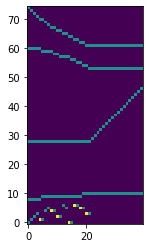

In [8]:
# Showing image reverted. More natural for humans, because higher values are higher. 
plt.imshow(image, origin='lower')

In [9]:
def create_images_for_split(data, components):
    data_images = []
    for split in trange(len(data)):
        X = data[split][0]
        y = data[split][1]
        images = []
        for game in range(len(X)):
            image = create_image(X[game], components)
            images.append(image)
        split_data = ((images, y))
        data_images.append(split_data)
    return data_images
    
def create_images(components=[True, True, True, True, True]):
    real_data_splits_train_images = create_images_for_split(real_data_splits_train, components)
    real_data_splits_test_images = create_images_for_split(real_data_splits_test, components)
    simulated_data_splits_train_images = create_images_for_split(simulated_data_splits_train, components)
    return real_data_splits_train_images, real_data_splits_test_images, simulated_data_splits_train_images 
    #return real_data_splits_train_images[0][0][24]

In [10]:
real_data_splits_train_images, real_data_splits_test_images, simulated_data_splits_train_images = \
    create_images(components=[True, True, True, True, True])

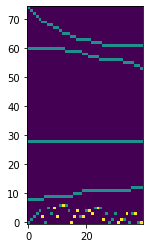

In [11]:
# Unclear noObst indices: 8?, 12
# Unclear glare indices: 23, 26?, 27, 32, 36, 

plt.imshow(real_data_splits_train_images[0][0][12], origin='lower') 

In [12]:
real_data_splits_train[0][1]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [13]:
real_data_splits_test

[(array([[[ 1.1, 14. , 13. ,  1. ,  0. ],
          [ 1.2, 12. , 12. ,  1. ,  0. ],
          [ 2.1, 12. , 11. ,  1. ,  0. ],
          [ 3.1, 12. , 10. ,  1. ,  0. ],
          [ 4.1, 12. ,  9. ,  1. ,  0. ],
          [ 5.1, 12. ,  8. ,  1. ,  0. ],
          [ 5.2, 12. ,  7. ,  1. ,  0. ],
          [ 5.1, 10. ,  7. ,  2. ,  0. ],
          [ 6.1, 10. ,  6. ,  2. ,  0. ],
          [ 3.2, 10. ,  5. ,  2. ,  0. ],
          [ 3.1, 10. ,  5. ,  2. ,  0. ],
          [ 3.2,  8. ,  5. ,  2. ,  0. ],
          [ 6.2,  8. ,  4. ,  2. ,  0. ],
          [ 4.1,  8. ,  4. ,  2. ,  0. ],
          [ 2.2,  8. ,  3. ,  2. ,  0. ],
          [ 2.1,  6. ,  3. ,  2. ,  0. ],
          [ 7.1,  6. ,  2. ,  2. ,  0. ],
          [ 7.2,  4. ,  1. ,  2. ,  0. ],
          [ 4.2,  4. ,  0. ,  2. ,  0. ],
          [ 6.1,  4. ,  0. ,  2. ,  0. ],
          [ 4.1,  4. ,  0. ,  3. ,  0. ],
          [ 4.2,  2. ,  0. ,  3. ,  0. ],
          [ 6.2,  2. ,  0. ,  3. ,  0. ],
          [ 6.1,  0. ,  0. ,  3. ,

In [14]:
n_participants_per_split = 19 # 20 but one is removed in each split for testing
simulations_per_participant = 1000
n_added_simulations_per_participant = 5
n_runs = 20
n_epochs = 100

In [15]:
def add_simulated_data(X_train, y_train, simulated_train_set):
    for n in range(n_added_simulations_per_participant):
        for i in range(n_participants_per_split):

            X_train_simulated_1 = simulated_train_set[0][(i * simulations_per_participant) + n]
            y_train_simulated_1 = simulated_train_set[1][(i * simulations_per_participant) + n]
            X_train_simulated_2 = simulated_train_set[0][(simulations_per_participant * n_participants_per_split) \
                                                         + (i * simulations_per_participant) + n]
            y_train_simulated_2 = simulated_train_set[1][(simulations_per_participant * n_participants_per_split) \
                                                         + (i * simulations_per_participant) + n]
            
            X_train_simulated = np.concatenate((X_train_simulated_1[np.newaxis, :, :], \
                                               X_train_simulated_2[np.newaxis, :, :]), axis=0)
            y_train_simulated = np.concatenate((y_train_simulated_1[np.newaxis, :], \
                                               y_train_simulated_2[np.newaxis, :]), axis=0)

            X_train = np.concatenate((X_train, X_train_simulated), axis=0)
            y_train = np.concatenate((y_train, y_train_simulated), axis=0)
    return X_train, y_train

In [16]:
def mean_score_of_run(histories, epochs):
    mean_val_losses = []
    mean_val_accuracies = []
    mean_losses = []
    mean_accuracies = []
    for i in range(epochs):
        val_losses = []
        val_accuracies = []
        losses = []
        accuracies = []
        for l in range(len(histories)):
            history = histories[l]
            val_losses.append(history.history['val_loss'][i])
            val_accuracies.append(history.history['val_accuracy'][i])
            losses.append(history.history['loss'][i])
            accuracies.append(history.history['accuracy'][i])
        mean_val_losses.append(np.mean(val_losses))
        mean_val_accuracies.append(np.mean(val_accuracies))
        mean_losses.append(np.mean(losses))
        mean_accuracies.append(np.mean(accuracies))
    return mean_val_losses, mean_val_accuracies, mean_losses, mean_accuracies

In [17]:
def mean_score_over_all_runs(mean_run_scores, n_runs):
    val_losses = np.asarray(mean_run_scores[0][0])
    val_accuracies = np.asarray(mean_run_scores[0][1])
    losses = np.asarray(mean_run_scores[0][2])
    accuracies = np.asarray(mean_run_scores[0][3])
                            
    for i in range(1, n_runs):
        val_losses += np.asarray(mean_run_scores[i][0])
        val_accuracies += np.asarray(mean_run_scores[i][1])
        losses += np.asarray(mean_run_scores[i][2])
        accuracies += np.asarray(mean_run_scores[i][3])
                                 
    val_losses /= n_runs
    val_accuracies /= n_runs
    losses /= n_runs
    accuracies /= n_runs
    
    return val_losses, val_accuracies, losses, accuracies

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [19]:
def create_and_train(X_train, y_train, X_test, y_test):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    cnn_input_shape = X_train[0].shape
    #epochs = n_epochs
    cnn_batch_size = 32 #1000
    #verbose = 0
    
    #print(cnn_input_shape)
    
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=cnn_input_shape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(10, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=cnn_batch_size, verbose=0, 
                        shuffle=True, validation_data=(X_test, y_test))
    
    #print(history.history['val_accuracy'])
    
    histories.append(history)

In [ ]:
mean_run_scores = []
for i in trange(n_runs, desc='Runs'): 
    histories = []
    for train_set, test_set, simulated_train_set in tqdm(zip(real_data_splits_train_images, \
                                    real_data_splits_test_images, simulated_data_splits_train_images), total=20, desc='Folds'):
        
        X_train = train_set[0]
        y_train = train_set[1]
        X_test = test_set[0]
        y_test = test_set[1]
        
        # Adding simulated data. 
        X_train, y_train = add_simulated_data(X_train, y_train, simulated_train_set)   
        
        #print(X_train.shape)
        #print(y_train.shape) 

        # Shuffling training data
        temp_train = list(zip(X_train, y_train.tolist()))
        random.shuffle(temp_train)
        X_train, y_train = zip(*temp_train)
        
        create_and_train(np.asarray(X_train), np.asarray(y_train), np.asarray(X_test), y_test)
        
    mean_run_score = mean_score_of_run(histories=histories, epochs=n_epochs)
    mean_run_scores.append(mean_run_score)

In [ ]:
mean_val_losses, mean_val_accuracies, mean_losses, mean_accuracies = mean_score_over_all_runs(mean_run_scores, n_runs)
mean_val_accuracies

In [ ]:
plt.title('glareObs_noAdapt: Best validation accuracy %s%% (at epoch %s)' \
          %(round(mean_val_accuracies.max() * 100, 2), np.argmax(mean_val_accuracies) + 1))
plt.plot(mean_accuracies)
plt.plot(mean_val_accuracies)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train(RD_SD%sx)' %n_added_simulations_per_participant, 'validation(RD)'], loc='lower right')
plt.show()

In [ ]:
plt.title('glareObs_noAdapt: Lowest validation loss %s (at epoch %s)' \
          %(round(mean_val_losses.min(), 4), np.argmin(mean_val_losses) + 1))
plt.plot(mean_losses)
plt.plot(mean_val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train(RD_SD%sx)' %n_added_simulations_per_participant, 'validation(RD)'], loc='upper right')
plt.show()